In [26]:
# Step 1: Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from xgboost import XGBRegressor, plot_importance
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

sns.set(style="whitegrid", palette="muted", font_scale=1.1)

# Step 2: Load Data
df = pd.read_csv("bfs_monthly.csv")
print("Shape:", df.shape)
print(df.head())



Shape: (35189, 17)
  sa naics_sector series geo  year     jan     feb     mar     apr     may  \
0  U        TOTAL  BA_BA  US  2025  497030  440230  497911  583054  425867   
1  U      NAICS11  BA_BA  US  2025    5141    4258    4398    4679    3128   
2  U      NAICS21  BA_BA  US  2025     547     472     511     575     407   
3  U      NAICS22  BA_BA  US  2025     689     663     697     789     594   
4  U      NAICS23  BA_BA  US  2025   49525   44621   47136   56485   40657   

      jun     jul     aug  sep  oct  nov  dec  
0  428742  513785  428937  NaN  NaN  NaN  NaN  
1    3041    3539    3019  NaN  NaN  NaN  NaN  
2     416     497     420  NaN  NaN  NaN  NaN  
3     595     684     663  NaN  NaN  NaN  NaN  
4   39051   45141   38607  NaN  NaN  NaN  NaN  


In [27]:
# Filter Data (US totals, overall business applications)
df_us = df[(df['geo'] == 'US') & 
           (df['naics_sector'] == 'TOTAL') & 
           (df['series'] == 'BA_BA')]

# Reshape Data
df_long = df_us.melt(
    id_vars=['year'],
    value_vars=['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec'],
    var_name='month',
    value_name='applications'
)

# Check structure
print(df_long.head())


   year month applications
0  2025   jan       497030
1  2025   jan       393232
2  2024   jan       577568
3  2024   jan       453575
4  2023   jan       441031


In [28]:
# Handle missing values and convert data types
df_long = df_long.dropna()
df_long['date'] = pd.to_datetime(df_long['year'].astype(str) + "-" + df_long['month'], format='%Y-%b')
df_long['applications'] = pd.to_numeric(df_long['applications'], errors='coerce')
df_long = df_long.sort_values('date')

print(df_long.info())


<class 'pandas.core.frame.DataFrame'>
Index: 508 entries, 307 to 309
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   year          508 non-null    int64         
 1   month         508 non-null    object        
 2   applications  508 non-null    int64         
 3   date          508 non-null    datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 19.8+ KB
None


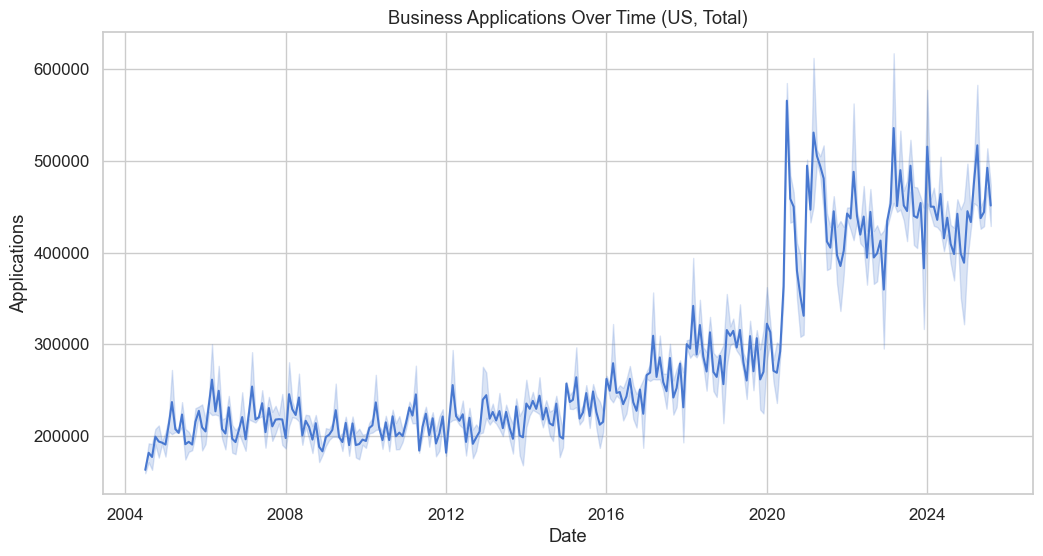

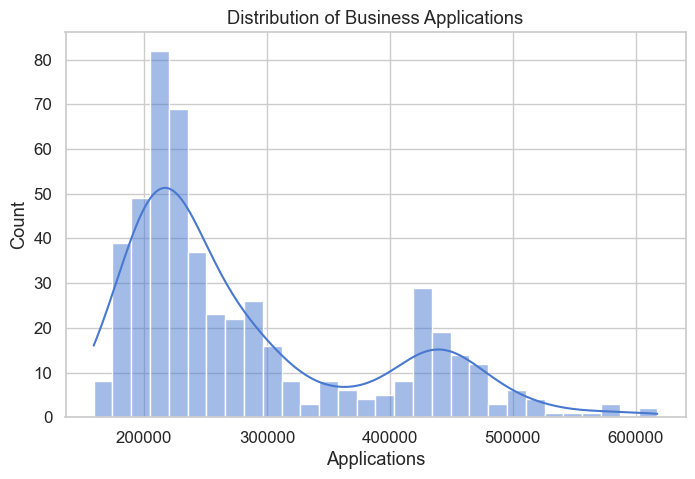

Missing values: year            0
month           0
applications    0
date            0
dtype: int64


In [29]:

# Line plot: Applications over time
plt.figure(figsize=(12,6))
sns.lineplot(data=df_long, x='date', y='applications')
plt.title("Business Applications Over Time (US, Total)")
plt.xlabel("Date")
plt.ylabel("Applications")
plt.show()

# Histogram: Distribution of applications
plt.figure(figsize=(8,5))
sns.histplot(df_long['applications'], bins=30, kde=True)
plt.xlabel("Applications")
plt.ylabel("Count")
plt.title("Distribution of Business Applications")
plt.show()

# Missing values check
print("Missing values:", df_long.isnull().sum())


RMSE: 20722.71, MAE: 16392.72, R²: 0.84


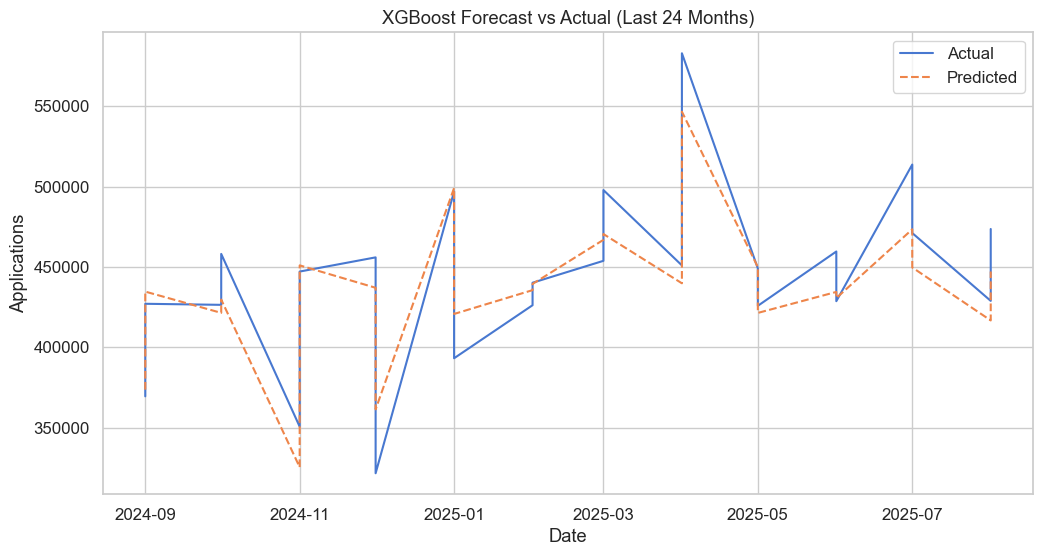

<Figure size 1000x600 with 0 Axes>

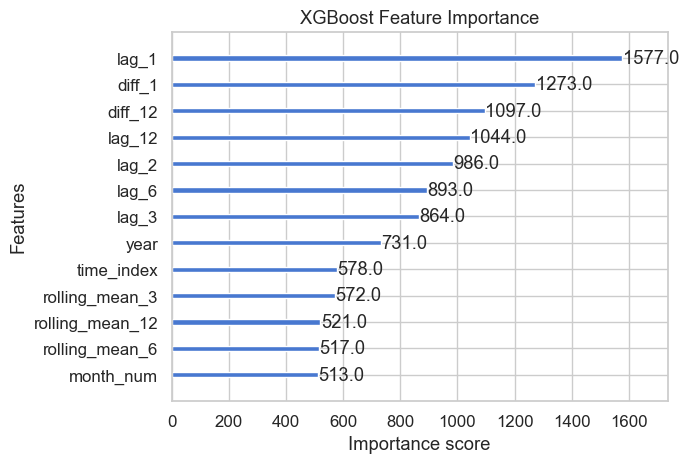

In [31]:

# ====================================================
# Data Modeling
# ====================================================

# --- Feature Engineering ---
def create_features(df, lags=[1,2,3,6,12]):
    """
    Create time-series features for forecasting business applications.

    Parameters
    ----------
    df : pandas.DataFrame
        Must include 'applications' and 'date' columns.
    lags : list of int
        List of lag months to create as features.

    Returns
    -------
    pandas.DataFrame
        Original dataframe with lag, rolling mean, diff, and time features.
    """
    df = df.copy()
    for lag in lags:
        df[f"lag_{lag}"] = df['applications'].shift(lag)
    df["rolling_mean_3"] = df['applications'].shift(1).rolling(3).mean()
    df["rolling_mean_6"] = df['applications'].shift(1).rolling(6).mean()
    df["rolling_mean_12"] = df['applications'].shift(1).rolling(12).mean()
    df["diff_1"] = df['applications'].diff(1)
    df["diff_12"] = df['applications'].diff(12)
    df["time_index"] = np.arange(len(df))
    df["month_num"] = df['date'].dt.month
    df["year"] = df['date'].dt.year
    return df

df_features = create_features(df_long).dropna()

# Train/Test Split (last 24 months for test)
train = df_features.iloc[:-24]
test = df_features.iloc[-24:]

X_train = train.drop(['date','applications','month'], axis=1)
y_train = train['applications']
X_test = test.drop(['date','applications','month'], axis=1)
y_test = test['applications']

# Train XGBoost
model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluate Model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.2f}")

# Plot Actual vs Predicted
plt.figure(figsize=(12,6))
plt.plot(test['date'], y_test, label="Actual")
plt.plot(test['date'], y_pred, label="Predicted", linestyle="--")
plt.title("XGBoost Forecast vs Actual (Last 24 Months)")
plt.xlabel("Date")
plt.ylabel("Applications")
plt.legend()
plt.show()

# Feature Importance
plt.figure(figsize=(10,6))
plot_importance(model, importance_type="weight", max_num_features=15)
plt.title("XGBoost Feature Importance")
plt.show()


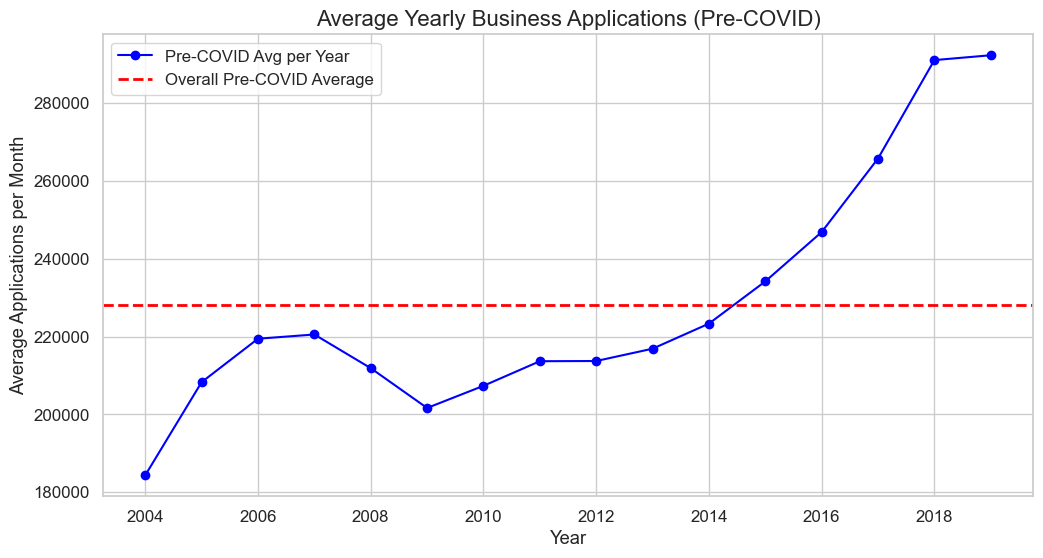

In [38]:
# Yearly averages
df_yearly = df_long.groupby(df_long['date'].dt.year)['applications'].mean().reset_index()
df_yearly.columns = ['year', 'avg_applications']

# Filter pre-COVID (before 2020)
pre_covid = df_yearly[df_yearly['year'] < 2020]

plt.figure(figsize=(12,6))
plt.plot(pre_covid['year'], pre_covid['avg_applications'], marker='o', color='blue', label="Pre-COVID Avg per Year")

# Add overall pre-COVID average line
plt.axhline(pre_covid['avg_applications'].mean(), color='red', linestyle='--', linewidth=2, label="Overall Pre-COVID Average")

plt.title("Average Yearly Business Applications (Pre-COVID)", fontsize=16)
plt.xlabel("Year")
plt.ylabel("Average Applications per Month")
plt.legend()
plt.grid(True)
plt.show()



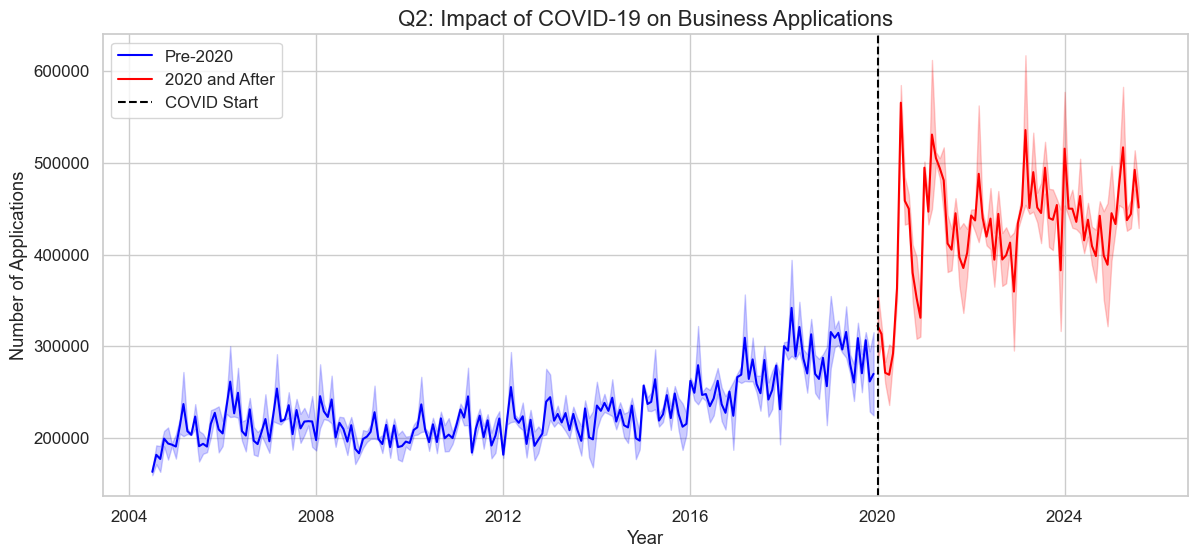

👉 The chart shows a structural break starting in 2020, where monthly applications nearly doubled compared to the pre-pandemic baseline.


In [36]:
plt.figure(figsize=(14,6))
sns.lineplot(data=df_long[df_long['date'] < "2020-01-01"], x='date', y='applications', label="Pre-2020", color="blue")
sns.lineplot(data=df_long[df_long['date'] >= "2020-01-01"], x='date', y='applications', label="2020 and After", color="red")
plt.axvline(pd.to_datetime("2020-01-01"), color="black", linestyle="--", label="COVID Start")
plt.title("Q2: Impact of COVID-19 on Business Applications", fontsize=16)
plt.xlabel("Year")
plt.ylabel("Number of Applications")
plt.legend()
plt.grid(True)
plt.show()

print("The chart shows a structural break starting in 2020, where monthly applications nearly doubled compared to the pre-pandemic baseline.")


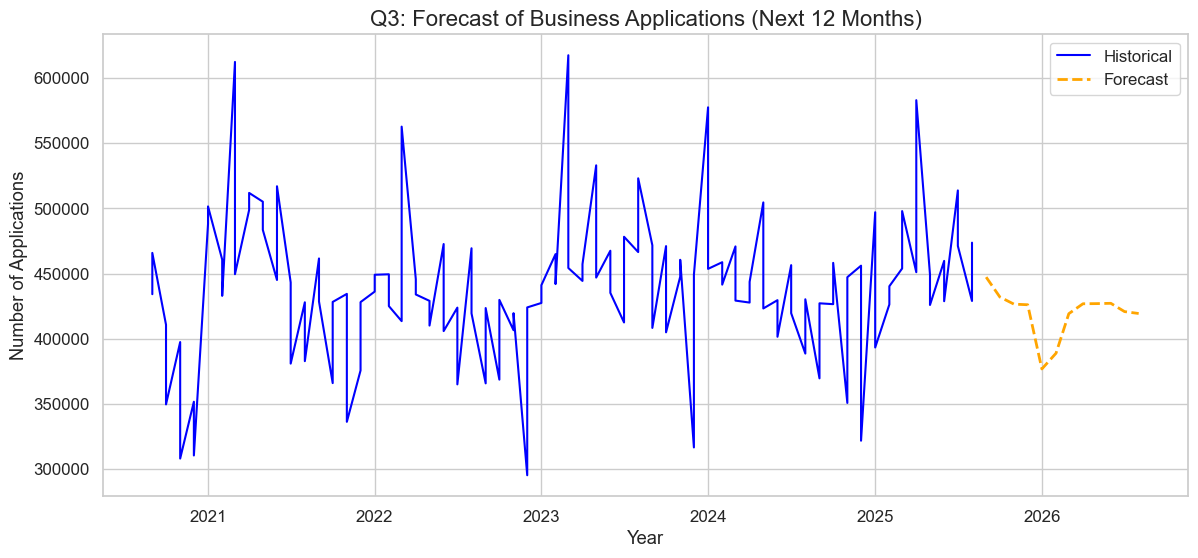

👉 The model captures the general upward trend and seasonality, but struggles with sudden spikes. Forecasts suggest applications will remain high but may stabilize over the next year.


In [37]:
plt.figure(figsize=(14,6))
cutoff_date = df_features['date'].max() - pd.DateOffset(years=5)

# Historical values
plt.plot(
    df_features.loc[df_features['date'] > cutoff_date, 'date'],
    df_features.loc[df_features['date'] > cutoff_date, 'applications'],
    label="Historical",
    color="blue"
)

# Forecast values
plt.plot(
    forecast_df['date'],
    forecast_df['applications'],
    label="Forecast",
    linestyle="--",
    color="orange",
    linewidth=2
)

plt.title("Q3: Forecast of Business Applications (Next 12 Months)", fontsize=16)
plt.xlabel("Year")
plt.ylabel("Number of Applications")
plt.legend()
plt.grid(True)
plt.show()

print("The model captures the general upward trend and seasonality, but struggles with sudden spikes. Forecasts suggest applications will remain high but may stabilize over the next year.")
